## Exercise 2 
**Machine Learning and Pattern Recognition**
Fredrik Fagerholm, 608987

### Facial recognition using deep learning
We develop and evaluate a deep learning model for facial recognition. A simple Convolution Neural Network (CNN) is implemented and evaluated on the *extended Yale Face Database B* data set. We find that the model is well suited for this task, giving an estimated classification accuracy of $0.999$ on unseen data.

In [65]:
# -*- coding: utf-8 -*-
import os
import zipfile
import fnmatch
import logging
import numpy as np
import imageio
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set seed for reproducibility
np.random.seed(0)

log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)

In [2]:
def read_image_data(input_file, output_file, 
                    file_format='*.pgm', img_dim=(192, 168), n_samples=2424):
    """ 
    Runs data processing scripts to turn raw image data from (../raw) into
    cleaned data in form of NumPy arrays (saved in ../processed).
    """    
    logger.info('making data set from raw image data')

    img_height, img_width = img_dim
    # initialize arrays for data
    image_data = np.empty(shape=(n_samples, img_height, img_width, 1), dtype='float32')
    labels = np.empty(shape=(n_samples, 1), dtype='<U10')

    logger.info('reading image data from: {}'.format(input_file))

    index = 0
    # read image data and save as vectors
    # open compressed data directory
    with zipfile.ZipFile(input_file, 'r') as z:
        for filename in fnmatch.filter(z.namelist(), file_format):
            # extract file
            infile = z.extract(filename)
            # read image as grayscale
            image = imageio.imread(infile)
            # check that the image has correct dimensions
            if image.shape == img_dim:
                # save image vector
                image_data[index, :, :, :] = image.reshape((img_height, img_width, 1))
                # use directory name as label for sample
                labels[index, :] = os.path.dirname(filename).split('/')[1]
                index += 1
            else:
                logger.error('wrong dimensions: {}, image not saved'.format(filename))

    # normalize image data to range [0, 1]
    image_data /= 255.0

    # count unique class names
    n_classes = np.unique(labels).shape[0]

    logger.info('{} images read'.format(index))
    logger.info('{} unique labels'.format(n_classes))
    
    # save data
    np.savez(output_file, features=image_data, labels=labels)
    
    return image_data, labels

In [31]:
# read images from file, standardize and tranform to appropriate form
raw_data_filepath = '../data/raw/CroppedYale.zip'
processed_data_filepath = '../data/processed/image_data.npz'
train_test_data_filepath = '../data/processed/train_test_data.npz'

if os.path.isfile(processed_data_filepath):
    # if already processed image data, read clean data from file
    with np.load(processed_data_filepath) as data:
        X = data['features']
        labels = data['labels'].ravel()
    
    logger.info('data loaded')
else:
    # otherwise, process raw data and save clean data to file
    X, labels = read_image_data(raw_data_filepath, processed_data_filepath)

# convert string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
# count number of classes
num_classes = np.unique(y).shape[0]

# split to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                        test_size=0.20, stratify=y)

# convert labels to binary 'one-hot' representation
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

# save train and test data
#np.savez(train_test_data_filepath, X_train=X_train, y_train=y_train, 
#                                   X_test=X_test, y_test=y_test) 

img_height, img_width = 192, 168
num_samples = X.shape[0]

2018-05-08 19:33:37,359 - __main__ - INFO - data loaded


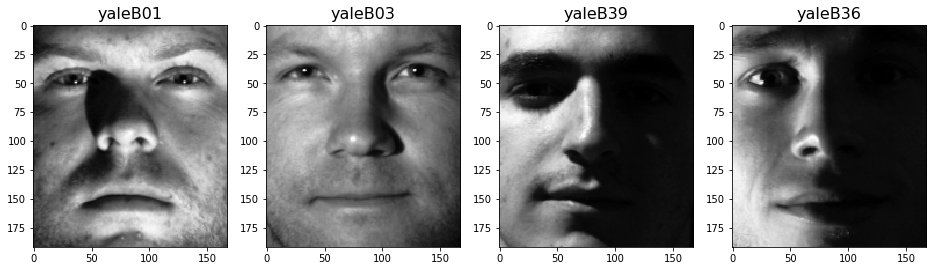

In [7]:
# plot random sample of images from the data set
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
# choose random indices uniformly
random_index = np.random.choice(np.arange(num_samples), size=(4), replace=False)

for col, index in enumerate(random_index):
    ax[col].set_title(labels[index], fontsize=16)
    # reshape image to original dimensions
    image = X[index, :].reshape(img_height, img_width)
    # plot image
    ax[col].imshow(image, cmap=plt.cm.Greys_r)

plt.savefig('../reports/figures/image_sample.png', bbox_inches='tight')
plt.show()

In [24]:
time_now = '2018-05-07_20-31-14'
# train Convolutional neural network
model_filepath = '../models/cnn_model_{}.hdf5'.format(time_now)
history_filepath = '../models/training_history_{}.pkl'.format(time_now)

if os.path.isfile(model_filepath) and \
    os.path.isfile(history_filepath):
    # if model already trained, load model
    model = keras.models.load_model(model_filepath)
    with open(history_filepath, 'rb') as infile:
        training_history = pickle.load(infile)

else:
    # build model and train
    model = Sequential()
    # input: 192x168 images with 1 channel -> (192, 168, 1) tensors.
    # convolutional "feature extraction" layers
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(192, 168, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(36, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # fully connected "classification" layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # compile mode, use adaptive moment estimation optimzer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    
    logging.info('training CNN model')
    # train model, save model after each epoch
    history = model.fit(X_train, y_train, 
                        batch_size=32, epochs=30,
                        validation_data=(X_test, y_test),
                        callbacks=[
                            ModelCheckpoint('../models/cnn_model.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                            monitor='val_loss')
                        ])

    logging.info('saving model to: {}'.format(model_filepath))
    model.save(model_filepath)
    
    training_history = history.history
    
    logging.info('saving training history to: {}'.format(history_filepath))
    with open(history_filepath, 'wb') as outfile:
        pickle.dump(training_history, outfile)


2018-05-07 20:31:14,942 - root - INFO - training CNN model


Train on 1939 samples, validate on 485 samples
Epoch 1/30
1939/1939 [==============================] - 149s 77ms/step - loss: 3.4045 - acc: 0.1470 - val_loss: 1.7733 - val_acc: 0.6474
Epoch 2/30
1939/1939 [==============================] - 146s 75ms/step - loss: 0.8046 - acc: 0.7989 - val_loss: 0.1669 - val_acc: 0.9773
Epoch 3/30
1939/1939 [==============================] - 145s 75ms/step - loss: 0.1645 - acc: 0.9598 - val_loss: 0.0929 - val_acc: 0.9773
Epoch 4/30
1939/1939 [==============================] - 136s 70ms/step - loss: 0.0843 - acc: 0.9840 - val_loss: 0.0815 - val_acc: 0.9835
Epoch 5/30
1939/1939 [==============================] - 145s 75ms/step - loss: 0.0730 - acc: 0.9830 - val_loss: 0.0624 - val_acc: 0.9876
Epoch 6/30
1939/1939 [==============================] - 140s 72ms/step - loss: 0.0355 - acc: 0.9912 - val_loss: 0.0551 - val_acc: 0.9897
Epoch 7/30
1939/1939 [==============================] - 137s 71ms/step - loss: 0.0314 - acc: 0.9923 - val_loss: 0.0623 - val_acc: 0

2018-05-07 21:42:19,820 - root - INFO - saving model to: ../models/cnn_model_2018-05-07_20-31-14.hdf5
2018-05-07 21:42:20,648 - root - INFO - saving training history to: ../models/training_history_2018-05-07_20-31-14.pkl


In [11]:
plot_model(model, to_file='../reports/figures/model.png', show_shapes=True)

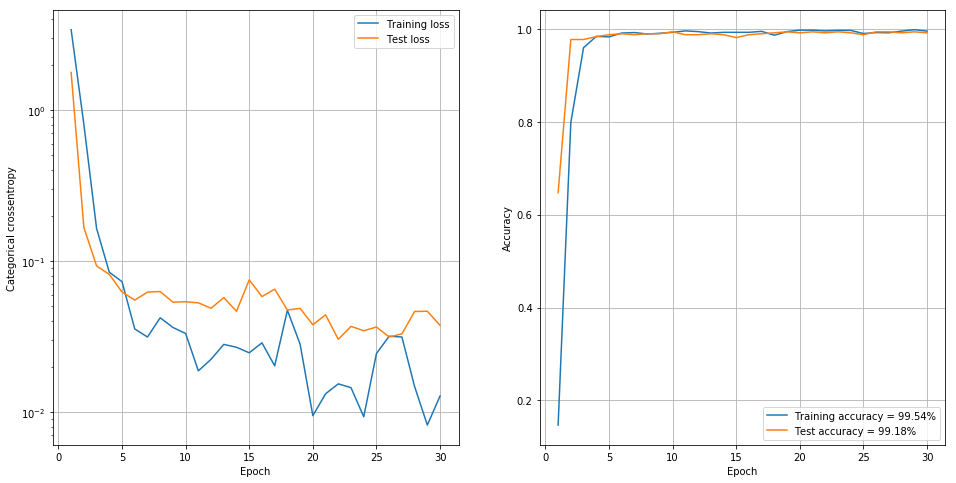

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

train_acc = training_history['acc'][-1] * 100
test_acc = training_history['val_acc'][-1] * 100

epochs = np.arange(1, len(training_history['loss']) + 1, dtype=int)

ax1.set_yscale('log')
ax1.plot(epochs, training_history['loss'], label="Training loss")
ax1.plot(epochs, training_history['val_loss'], label="Test loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Categorical crossentropy')
ax1.grid()
ax1.legend()

ax2.plot(epochs, training_history['acc'], label="Training accuracy = {:.2f}%".format(train_acc))
ax2.plot(epochs, training_history['val_acc'], label="Test accuracy = {:.2f}%".format(test_acc))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.savefig('../reports/figures/validation_curve.png', bbox_inches='tight')
plt.show()

In [33]:
y_pred = model.predict_classes(X_test)
y_prob = model.predict_proba(X_test)

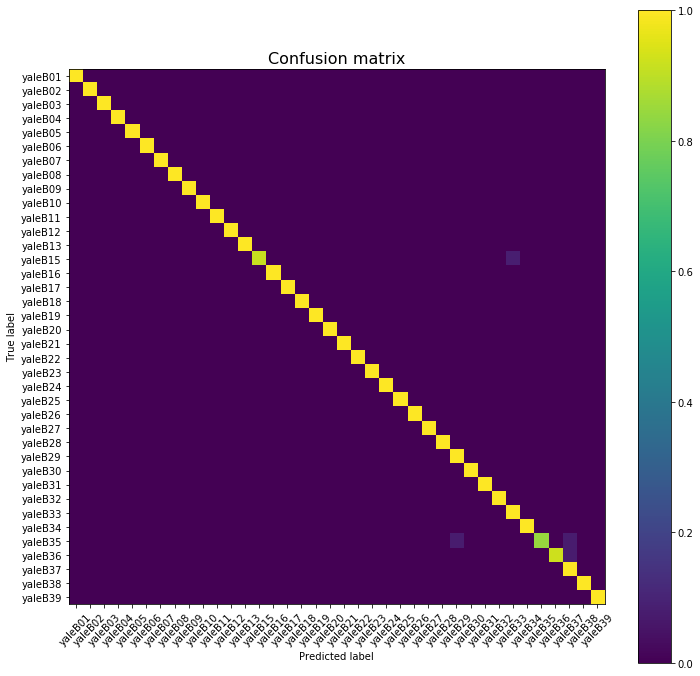

In [66]:
class_names = np.sort(np.unique(labels))

# compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(cnf_matrix, interpolation='nearest')
ax.set_title('Confusion matrix', fontsize=16)
fig.colorbar(cax)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.savefig('../reports/figures/confusion_matrix.png', bbox_inches='tight')
plt.show()

c:\users\fredrik.fagerholm\envs\mlpr2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\fredrik.fagerholm\envs\mlpr2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['yaleB36' 'yaleB35' 'yaleB35' 'yaleB15']


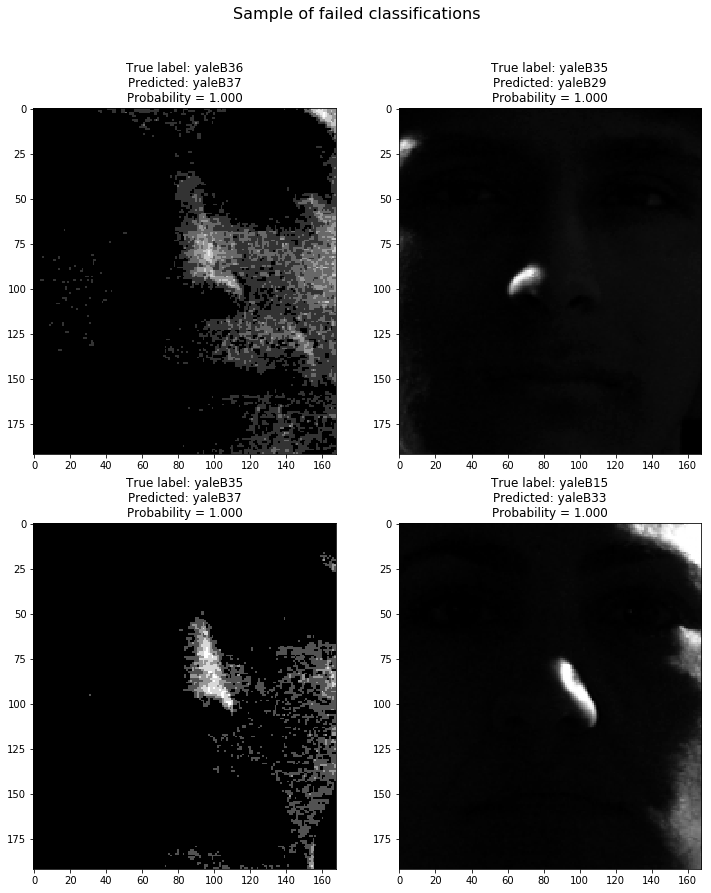

In [77]:
# show a number of failed classifications

# decode class label names from predicted and true encoded classes
true_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
pred_classes = label_encoder.inverse_transform(y_pred)
pred_prob = np.max(y_prob, axis=1)

ROWS, COLS = 2, 2
# choose a number of random failed classifications
error_index = np.random.choice(np.argwhere(pred_classes != true_classes).ravel(), 
                               ROWS*COLS, replace=False)

print('Wrong classififcations', true_classes[error_index])

fig, ax = plt.subplots(ncols=COLS, nrows=ROWS, figsize=(12, 14))

for ix, err_ix in enumerate(error_index):
    rix, cix = divmod(ix, COLS)
    
    true = true_classes[err_ix]
    pred = pred_classes[err_ix]
    prob = pred_prob[ix]
    title = 'True label: {}\nPredicted: {}\nProbability = {:.3f}'.format(true, pred, prob)
    ax[rix, cix].set_title(title)
    
    image = X_test[err_ix].reshape(img_height, img_width)
    # plot image
    ax[rix, cix].imshow(image, cmap=plt.cm.Greys_r)
    
plt.suptitle('Sample of failed classifications', fontsize=16)
plt.savefig('../reports/figures/wrong_predictions.png', bbox_inches='tight')
plt.show(block=True)

In [80]:
!jupyter nbconvert --to python MLPR_Exercise_2_Fagerholm.ipynb --template=no_in_prompt.tpl

[NbConvertApp] Converting notebook MLPR_Exercise_2_Fagerholm.ipynb to python
[NbConvertApp] Writing 10230 bytes to MLPR_Exercise_2_Fagerholm.py
